In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers


In [2]:
# Define network and training parameters
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 1000  # Increased buffer size for better shuffling
LEARNING_RATE = 0.0001  # Reduced learning rate

images_dir = 'arcgis-survey-images'

In [3]:
# Get class names (subdirectories) and assign numeric labels
class_names = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

print(f"Classes found: {class_names}")


Classes found: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


In [4]:
# Create lists to store file paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(images_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_label[class_name])

In [5]:
# Create the DataFrame
data_df = pd.DataFrame({
    'filepath': image_paths,
    'label': labels
})

print(f"Original class distribution:\n{data_df['label'].value_counts()}")

Original class distribution:
label
3    1001
2     837
0     825
1     404
4     222
Name: count, dtype: int64


In [6]:
# Split into training and validation sets
train_df, val_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df['label'],
    random_state=SEED
)

In [7]:
print(f"Class distribution in training before balancing:\n{train_df['label'].value_counts()}")
print(f"Class distribution in validation:\n{val_df['label'].value_counts()}")

# Step 1: Examine the Class Distribution in Training Set
print("Class distribution in the training set:")
print(train_df['label'].value_counts())

Class distribution in training before balancing:
label
3    801
2    669
0    660
1    323
4    178
Name: count, dtype: int64
Class distribution in validation:
label
3    200
2    168
0    165
1     81
4     44
Name: count, dtype: int64
Class distribution in the training set:
label
3    801
2    669
0    660
1    323
4    178
Name: count, dtype: int64


In [8]:
# Step 2: Resample Classes to a Fixed Count of 300

# Set the target class count
target_count = 300

print(f"Target class count for balancing: {target_count}")

# Separate classes
df_list = [train_df[train_df['label'] == i] for i in train_df['label'].unique()]

# Resample classes
df_resampled = []
for df in df_list:
    class_label = df['label'].iloc[0]
    class_count = len(df)
    if class_count > target_count:
        # Downsample majority classes
        df_resampled.append(df.sample(n=target_count, random_state=SEED))
        print(f"Class {class_label}: Downsampled from {class_count} to {target_count}")
    elif class_count < target_count:
        # Upsample minority classes
        df_resampled.append(resample(df, replace=True, n_samples=target_count, random_state=SEED))
        print(f"Class {class_label}: Upsampled from {class_count} to {target_count}")
    else:
        df_resampled.append(df)
        print(f"Class {class_label}: No resampling needed")
        
# Combine back to a single DataFrame
train_df_balanced = pd.concat(df_resampled)

# Shuffle the DataFrame
train_df_balanced = train_df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("Class distribution after resampling:")
print(train_df_balanced['label'].value_counts())


Target class count for balancing: 300
Class 3: Downsampled from 801 to 300
Class 0: Downsampled from 660 to 300
Class 2: Downsampled from 669 to 300
Class 1: Downsampled from 323 to 300
Class 4: Upsampled from 178 to 300
Class distribution after resampling:
label
2    300
4    300
0    300
1    300
3    300
Name: count, dtype: int64


In [9]:
# Step 3: Update the Data Pipeline
# Function to extract paths and labels from DataFrame
def path_to_image_label(df):
    return df['filepath'].values, df['label'].values


In [10]:
# Extract paths and labels from the balanced DataFrame
train_paths_balanced, train_labels_balanced = path_to_image_label(train_df_balanced)
val_paths, val_labels = path_to_image_label(val_df)

# Create TensorFlow Datasets
train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_paths_balanced, train_labels_balanced))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# Step 5: Verify Image Preprocessing and Enhance Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

In [11]:
def load_and_preprocess_image_flexible(path, label):
    try:
        image = tf.io.read_file(path)
        # Detect file type and decode accordingly
        file_extension = tf.strings.lower(tf.strings.split(path, '.')[-1])
        image = tf.case([
            (tf.equal(file_extension, 'jpg'), lambda: tf.image.decode_jpeg(image, channels=3)),
            (tf.equal(file_extension, 'jpeg'), lambda: tf.image.decode_jpeg(image, channels=3)),
            (tf.equal(file_extension, 'png'), lambda: tf.image.decode_png(image, channels=3)),
        ], default=lambda: tf.image.decode_jpeg(image, channels=3), exclusive=True)
        image = tf.image.resize(image, IMAGE_SIZE)
        image = data_augmentation(image)
        image = image / 255.0  # Normalize to [0,1]
        return image, label
    except tf.errors.InvalidArgumentError:
        tf.print(f"Error processing image: {path}")
        return tf.zeros(INPUT_SHAPE), -1

In [12]:
def filter_invalid_images(image, label):
    # Filter out invalid labels (e.g., -1)
    return tf.not_equal(label, -1)

In [13]:
# Apply preprocessing and filter invalid images
train_ds_balanced = train_ds_balanced.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_balanced = train_ds_balanced.filter(filter_invalid_images)
train_ds_balanced = train_ds_balanced.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.filter(filter_invalid_images)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Step 6: Adjust Model Hyperparameters
# Reduced learning rate has been set above

# Step 7: Unfreeze More Layers in the Base Model
# Load the base model (MobileNetV2)
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[:75]:
    layer.trainable = False
for layer in base_model.layers[75:]:
    layer.trainable = True

base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,067,712 (7.89 MB)

 Non-trainable params: 190,272 (743.25 KB)

In [15]:
# Define the full model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,067,712 (7.89 MB)

 Non-trainable params: 190,272 (743.25 KB)

In [16]:
# Compile the model with a reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

tensorboard_log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [17]:
# Step 9: Monitor Training Closely
# Train the model
history = model.fit(
    train_ds_balanced,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
)

Epoch 1/50
     47/Unknown 30s 283ms/step - accuracy: 0.3076 - loss: 4.0746

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 3.68053, saving model to best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - accuracy: 0.3089 - loss: 4.0704 - val_accuracy: 0.4347 - val_loss: 3.6805 - learning_rate: 1.0000e-04
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6490 - loss: 3.2065
Epoch 2: val_loss improved from 3.68053 to 3.53626, saving model to best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.6493 - loss: 3.2051 - val_accuracy: 0.5046 - val_loss: 3.5363 - learning_rate: 1.0000e-04
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8040 - loss: 2.8040
Epoch 3: val_loss improved from 3.53626 to 3.40401, saving model to best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 404ms/step - accuracy: 0.8039 - loss: 2.8038 - val_accuracy: 0.5714 - val_loss: 3.4040 - learning_rate: 1.0000e-04
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8599 - loss: 2.5824
Epoch 4: val_loss did not improve from 3.40401
47/47

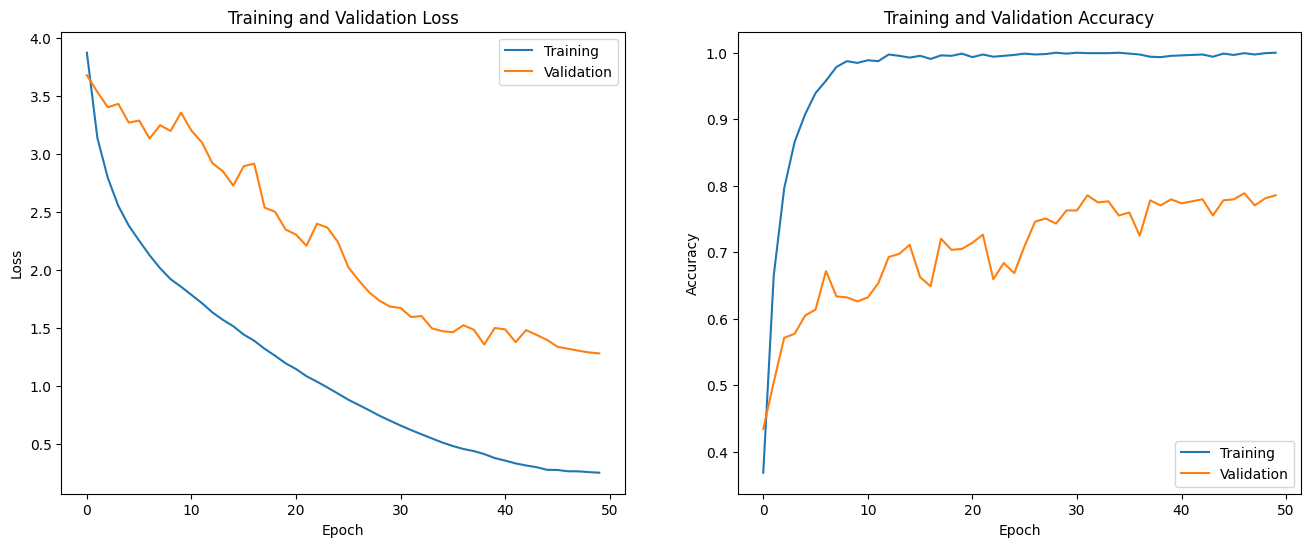

In [18]:
# Step 10: Visualize Training Performance
# Plot loss and accuracy
metrics = history.history
plt.figure(figsize=(16, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Training')
plt.plot(history.epoch, metrics['val_loss'], label='Validation')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Training')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validation')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8195 - loss: 1.1387
Test set evaluation:
accuracy: 0.8094
loss: 1.0893
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step


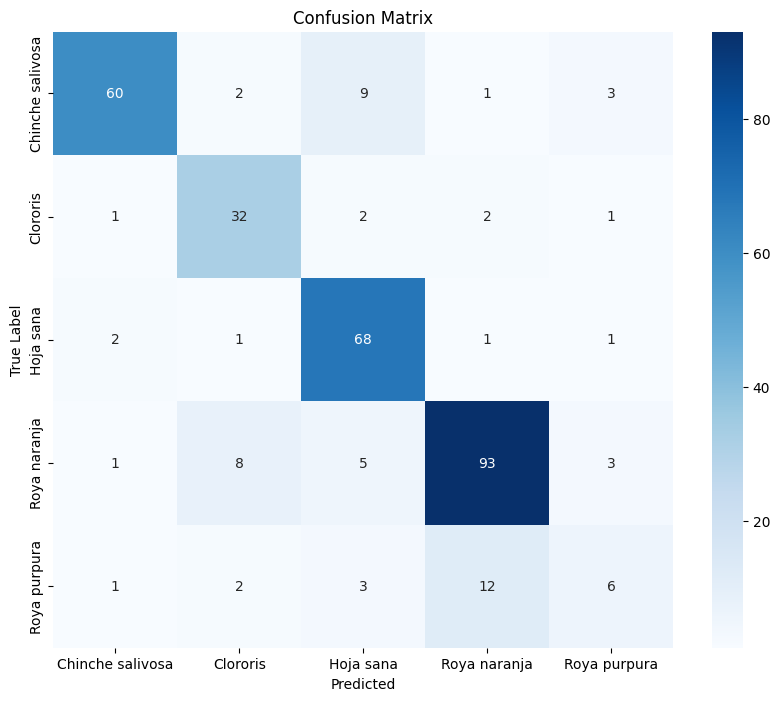

Updated classification report:
                  precision    recall  f1-score   support

Chinche salivosa       0.92      0.80      0.86        75
        Clororis       0.71      0.84      0.77        38
       Hoja sana       0.78      0.93      0.85        73
    Roya naranja       0.85      0.85      0.85       110
    Roya purpura       0.43      0.25      0.32        24

        accuracy                           0.81       320
       macro avg       0.74      0.73      0.73       320
    weighted avg       0.80      0.81      0.80       320



In [19]:
# Step 11: Evaluate the Improved Model
# Create a test dataset from the validation set
test_ds = val_ds.shard(num_shards=2, index=1)

# Evaluate the model on the test set
test_results = model.evaluate(test_ds, return_dict=True)
print("Test set evaluation:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Obtain predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes).numpy()

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Updated classification report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


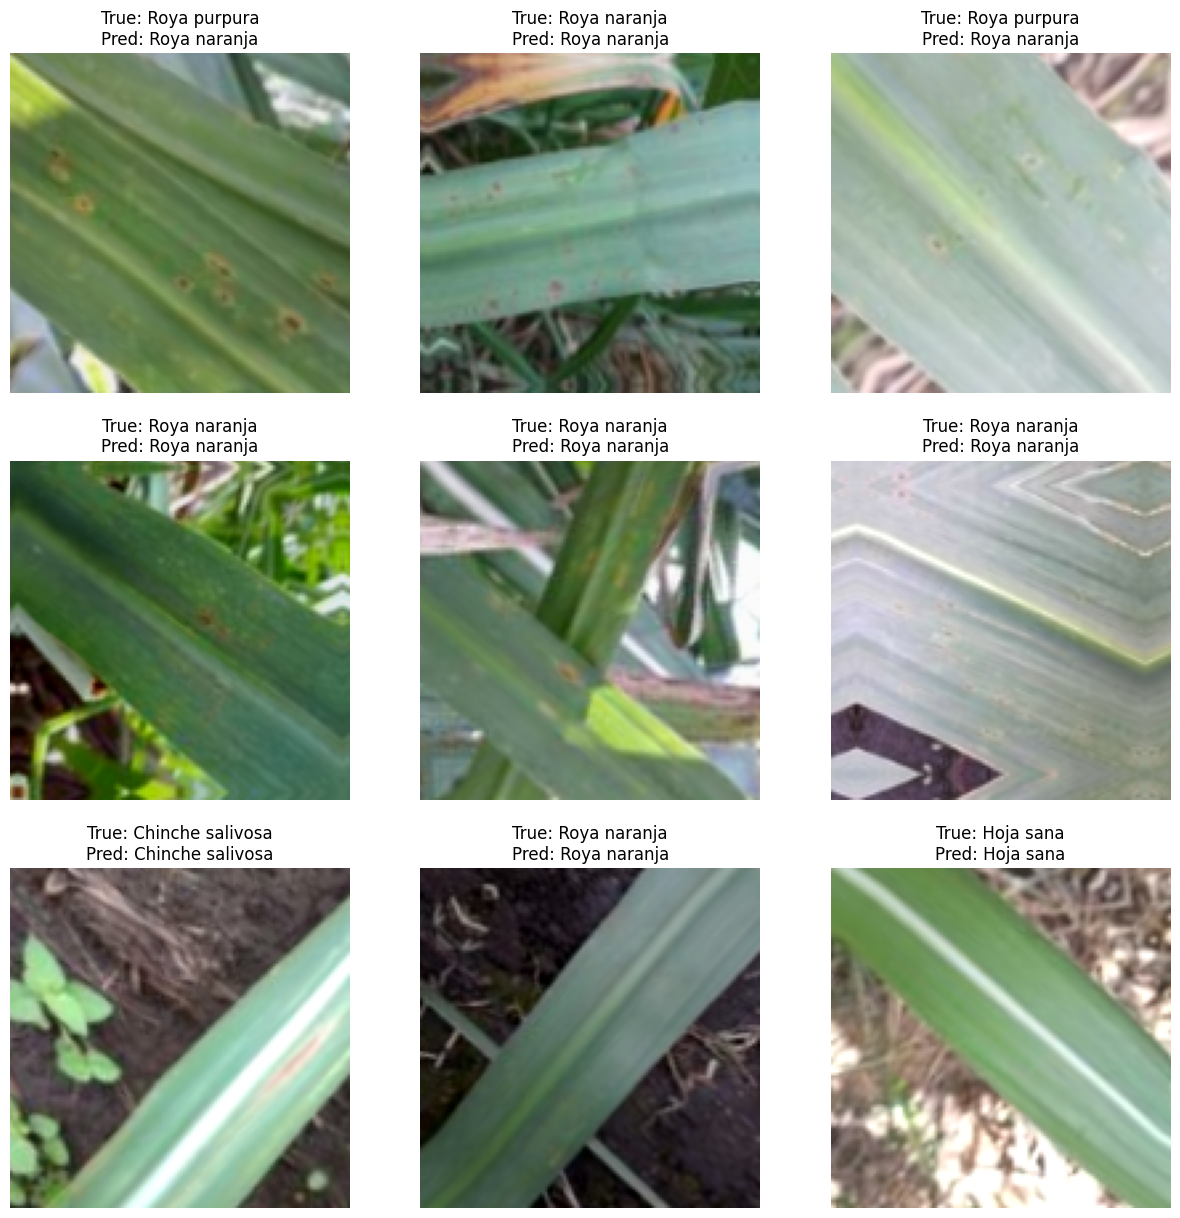

In [20]:
# Step 12: Visualize Some Predictions
import random

# Get a batch from the test dataset
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()
    break

# Randomly select images to display
indices = random.sample(range(images.shape[0]), min(9, images.shape[0]))

plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].numpy())
    true_label = class_names[true_classes[idx]]
    pred_label = class_names[pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.show()

In [21]:
# # Función para extraer rutas y etiquetas del DataFrame
# def path_to_image_label(df):
#     return df['filepath'].values, df['label'].values

# # Extraer rutas y etiquetas
# train_paths, train_labels = path_to_image_label(train_df)
# val_paths, val_labels = path_to_image_label(val_df)

# # Crear TensorFlow Datasets
# train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
# val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# # Aplicar la función de preprocesamiento y filtrar imágenes inválidas
# train_ds = train_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.filter(filter_invalid_images)
# train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# val_ds = val_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.filter(filter_invalid_images)
# val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [22]:
# # Verificar los datasets
# for images, labels in train_ds.take(1):
#     print(f"Batch de entrenamiento - imágenes: {images.shape}, etiquetas: {labels.shape}")

# for images, labels in val_ds.take(1):
#     print(f"Batch de validación - imágenes: {images.shape}, etiquetas: {labels.shape}")


In [23]:
# # Cargar el modelo base (MobileNetV2)
# base_model = MobileNetV2(input_shape=INPUT_SHAPE,
#                          include_top=False,
#                          weights='imagenet')

# # Congelar las primeras 100 capas del modelo base
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# base_model.summary()


In [24]:
# # Definir el modelo completo
# model = tf.keras.models.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(class_names), activation='softmax')  # Usar 'softmax' y from_logits=False
# ])

# model.summary()


In [25]:
# # Compilar el modelo con una tasa de aprendizaje fija
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])


In [26]:
# early_stop = EarlyStopping(monitor='val_loss',
#                            patience=10,
#                            restore_best_weights=True)


In [27]:
# checkpoint_path = 'best_model.keras'
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
#                                    monitor='val_loss',
#                                    save_best_only=True,
#                                    verbose=1)


In [28]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=5,
#                               min_lr=1e-6,
#                               verbose=1)


In [29]:
# tensorboard_log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)


In [30]:
# # Entrenamiento del modelo
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     class_weight=class_weights_dict,  # Aplicar ponderaciones de clase
#     callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
# )


In [31]:
# # Gráfica de la pérdida y precisión
# metrics = history.history
# plt.figure(figsize=(16, 6))

# # Pérdida
# plt.subplot(1, 2, 1)
# plt.plot(history.epoch, metrics['loss'], label='Entrenamiento')
# plt.plot(history.epoch, metrics['val_loss'], label='Validación')
# plt.legend()
# plt.ylim([0, max(metrics['loss'] + metrics['val_loss'])])
# plt.ylabel('Pérdida')
# plt.xlabel('Época')
# plt.title('Pérdida durante el Entrenamiento')

# # Precisión
# plt.subplot(1, 2, 2)
# plt.plot(history.epoch, metrics['accuracy'], label='Entrenamiento')
# plt.plot(history.epoch, metrics['val_accuracy'], label='Validación')
# plt.legend()
# plt.ylim([0, 1])
# plt.ylabel('Precisión')
# plt.xlabel('Época')
# plt.title('Precisión durante el Entrenamiento')

# plt.show()


In [32]:
# # Crear un conjunto de test a partir del conjunto de validación
# test_ds = val_ds.shard(num_shards=2, index=1)

# # Evaluar el modelo en el conjunto de test
# test_results = model.evaluate(test_ds, return_dict=True)
# print("Resultados de evaluación en test set:")
# for metric, value in test_results.items():
#     print(f"{metric}: {value:.4f}")


In [33]:
# # Obtener predicciones
# y_pred = model.predict(test_ds)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Obtener etiquetas verdaderas
# y_true = np.concatenate([y for x, y in test_ds], axis=0)

# # Calcular la matriz de confusión
# conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes).numpy()

# # Visualizar la matriz de confusión
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicción')
# plt.ylabel('Etiqueta Verdadera')
# plt.title('Matriz de Confusión')
# plt.show()


In [34]:
# # Reporte de clasificación
# print("Reporte de clasificación:")
# print(classification_report(y_true, y_pred_classes, target_names=class_names))
 